In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [ ]:
NUM_TO_TYPE = {
    0: 'benign',
    1: 'defacement',
    2: 'malware',
    3: 'phishing',
    4: 'spam'
}

In [ ]:
df = pd.read_csv("balanced_dataset.csv")
df

,url_length,num_digits,num_special_chars,num_subdomains,tld_length,path_length,query_length,num_query_params,type_encoded
0,83,18,16,0,2,68,0,0,0
1,83,23,17,0,2,68,0,0,0
2,83,22,17,0,2,68,0,0,0
3,83,18,19,0,2,68,0,0,0
4,83,18,17,0,2,68,0,0,0
...,...,...,...,...,...,...,...,...,...
2140395,59,13,11,2,5,22,0,0,4
2140396,52,12,11,2,5,21,0,0,4
2140397,81,27,12,2,5,55,0,0,4
2140398,108,25,16,1,5,27,53,3,4


In [ ]:
df.type_encoded.value_counts()

,count
type_encoded,
0,428080
1,428080
2,428080
3,428080
4,428080


In [ ]:
X = df.drop('type_encoded', axis=1)
y = df['type_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((1712320, 8), (428080, 8))

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Flatten
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.layers import Dropout

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
cnn_model = Sequential([
    Embedding(input_dim=len(X_train.columns), output_dim=64, input_length=len(X_train.columns)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(5, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
cnn_model = Sequential([
    Embedding(input_dim=len(X_train.columns), output_dim=128, input_length=len(X_train.columns)),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    Dropout(0.3),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
13378/13378 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.7830 - loss: 0.5218 - val_accuracy: 0.8052 - val_loss: 0.4570
Epoch 2/5
13378/13378 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.8010 - loss: 0.4717 - val_accuracy: 0.8070 - val_loss: 0.4520
Epoch 3/5
13378/13378 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.8019 - loss: 0.4680 - val_accuracy: 0.8080 - val_loss: 0.4485
Epoch 4/5
13378/13378 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step - accuracy: 0.8024 - loss: 0.4660 - val_accuracy: 0.8069 - val_loss: 0.4485
Epoch 5/5
13378/13378 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.8029 - loss: 0.4643 - val_accuracy: 0.8080 - val_loss: 0.4498


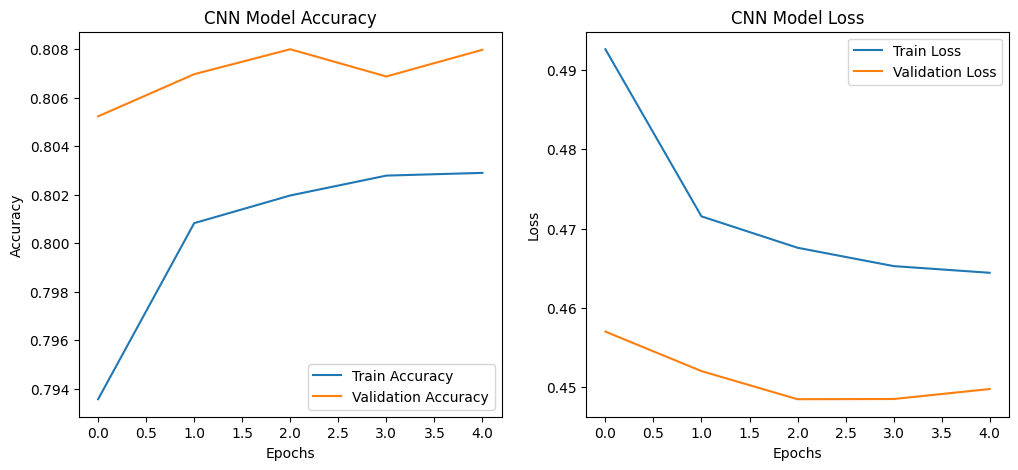

In [27]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(cnn_model.history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(cnn_model.history.history['loss'], label='Train Loss')
plt.plot(cnn_model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss')
plt.legend()

plt.show()

13378/13378 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step


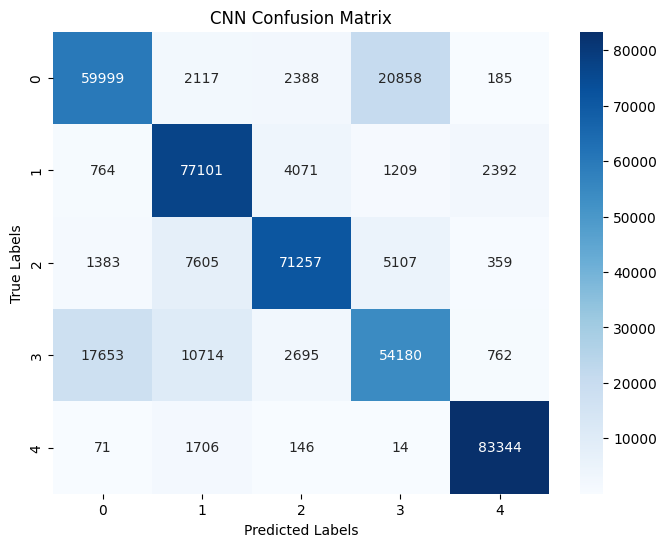

In [29]:
# Predict class labels
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Confusion Matrix')
plt.show()

13378/13378 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step


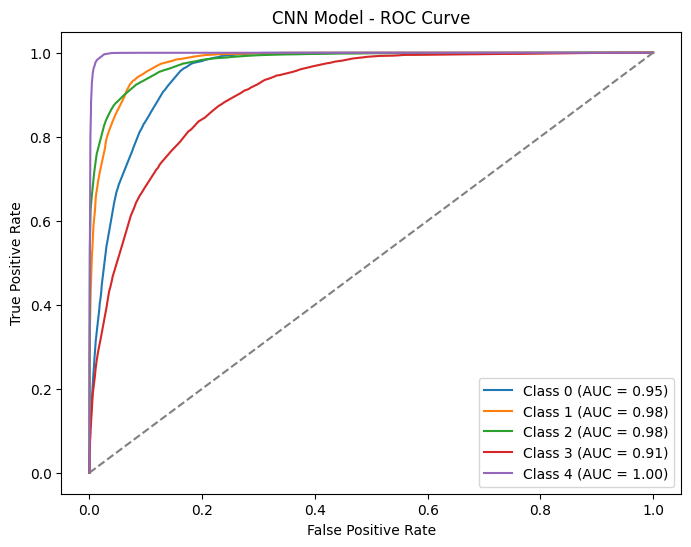

In [36]:
# Get CNN model probabilities
y_prob_cnn = cnn_model.predict(X_test)

# Binarize labels for multi-class ROC curve
y_test_binarized = tf.keras.utils.to_categorical(y_test, num_classes=5)

# Plot ROC Curve for CNN model
plt.figure(figsize=(8, 6))
for i in range(y_prob_cnn.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob_cnn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CNN Model - ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Fine-Tuned DistilBERT Model (Faster than BERT)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [22]:
df_llm = pd.read_csv("/content/merged_encoded_dataset.csv")

In [23]:
df_llm

,url,type,type_encoded
0,http://1337x.to/torrent/1048648/American-Snipe...,benign,0
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign,0
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign,0
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign,0
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign,0
...,...,...,...
653035,xbox360.ign.com/objects/850/850402.html,phishing,3
653036,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3
653037,www.gamespot.com/xbox360/action/deadspace/,phishing,3
653038,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3


In [24]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

def tokenize_function(urls):
    return tokenizer(urls, padding=True, truncation=True, max_length=128, return_tensors="tf")

# Prepare training and validation data
df_train, df_val = train_test_split(df_llm, test_size=0.2, random_state=42)

train_encodings = tokenize_function(df_train['url'].tolist())
val_encodings = tokenize_function(df_val['url'].tolist())

train_labels = tf.convert_to_tensor(df_train['type_encoded'].values)
val_labels = tf.convert_to_tensor(df_val['type_encoded'].values)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(16)

bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

bert_model.fit(train_dataset, validation_data=val_dataset, epochs=3)

# Evaluate the model
bert_model.evaluate(val_dataset)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

KeyboardInterrupt: 